In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
from scipy.stats import norm

In [ ]:
def plot_two_plots(sim_scenario, pi_target, pi_target_name):
    df_list = []

    for m in method_names:
        df_tmp = pd.read_csv('results/'+sim_scenario+'/'+m+'_pi_target'+pi_target_name+'.csv')
        df_tmp['method'] = m
        df_list.append(df_tmp)
    
    df = pd.concat(df_list, ignore_index=True)
    df['method'] = pd.Categorical(df['method'], categories=method_names, ordered=True)

    df_var = df.groupby(['method', 'n_target'], observed=True).agg(var_emp=('pi', lambda x: np.var(x, ddof=1))).reset_index()
    df_merged = pd.merge(df, df_var, on=['n_target', 'method'], how='left')

    df_tmp1 = pd.read_csv('results/'+sim_scenario+'/'+'rbf'+'_pi_target'+pi_target_name+'.csv')
    df_tmp1['method'] = 'ipr'
    df_tmp2 = pd.read_csv('results/'+sim_scenario+'/'+'rbf'+'_pi_target'+pi_target_name+'.csv')
    df_tmp2['method'] = 'nrm'
    df_tmp1 = pd.concat([df_tmp1, df_tmp2], ignore_index=True)
    df_tmp1['method'] = pd.Categorical(df_tmp1['method'], categories=method_names, ordered=True)

    # df_tmp1 = pd.read_csv('results/'+sim_scenario+'/'+'rbf'+'_pi_target'+pi_target_name+'.csv')
    # df_tmp1['method'] = 'ipr'


    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 5.5), sharex=False)

    flierprops = dict(marker='o', markersize=2, linestyle='none', markerfacecolor='darkgray')

    # --- Left plot ---
    sns.boxplot(ax=axes[0], data=df, x='n_target', y='pi', hue='method', flierprops=flierprops)
    axes[0].hlines(y=pi_target, xmin=-0.5, xmax=len(df['n_target'].unique())-0.5, linestyle='dotted', color='black')
    axes[0].set_title("Estimators")

    # --- Right plot ---
    sns.boxplot(ax=axes[1], data=df_merged, x='n_target', y='var_n', hue='method', boxprops={'alpha':0.5}, flierprops=flierprops)
    sns.stripplot(
        ax=axes[1],
        data=df_merged[['n_target', 'method', 'var_emp']].drop_duplicates(),
        x='n_target', y='var_emp', hue='method',
        dodge=True, size=6, marker="X", edgecolor='black', linewidth=1
    )
    sns.stripplot(
        ax=axes[1],
        data=df_tmp1[['n_target', 'method', 'var_n']],
        x='n_target', y='var_n', hue='method',
        dodge=True, size=6, marker="o", edgecolor='black', linewidth=1
    )
    axes[1].set_title("Variances")

    # Fix duplicate legends on right plot
    handles, labels = axes[1].get_legend_handles_labels()
    method_handles = handles[:len(df_merged['method'].unique())]
    method_labels = labels[:len(df_merged['method'].unique())]

    empirical_handle = Line2D(
        [0], [0], marker='X', color='w', label='Empirical variances',
        markerfacecolor='gray', markersize=6, markeredgecolor='black'
    )

    empirical_handle2 = Line2D(
        [0], [0], marker='o', color='w', label='True for Gaussian kernel',
        markerfacecolor='gray', markersize=6, markeredgecolor='black'
    )

    axes[1].legend(
        handles=method_handles + [empirical_handle] + [empirical_handle2],
        labels=method_labels + ['Empirical Variance'] + ['True for Gaussian kernel']
    )

    df_mse = df.groupby(['method', 'n_target'], observed=True).agg(mse=('pi', lambda x: np.mean((x - pi_target)**2))).reset_index()

    sns.barplot(ax=axes[2], data=df_mse, x='n_target', y='mse', hue='method')
    axes[2].set_title("MSE")

    fig.suptitle("Comparison of Estimators: "+sim_scenario+", pi_target="+str(pi_target), fontsize=16, weight='bold')

    plt.tight_layout()
    plt.show()

    # plt.figure(figsize=(12, 6))
    # sns.boxplot(df, x='n_target', y='pi', hue='method')
    # plt.hlines(y=0.7, xmin=0-0.5, xmax=6.5, color='black')
    # plt.show()

    
    # plt.figure(figsize=(12, 6))
    # sns.boxplot(df_merged, x='n_target', y='var_n', hue='method', boxprops={'alpha':0.5})
    # sns.stripplot(data=df_merged[['n_target', 'method', 'var_emp']].drop_duplicates(), x='n_target', y='var_emp', hue='method',
    #             dodge=True, size=8, marker="X", edgecolor='black', linewidth=1)
    # # Fix duplicate legends
    # handles, labels = plt.gca().get_legend_handles_labels()
    # # Only keep one set of method handles
    # method_handles = handles[:len(df_merged['method'].unique())]
    # method_labels = labels[:len(df_merged['method'].unique())]

    # # Add a custom handle for empirical variance
    # empirical_handle = Line2D([0], [0], marker='X', color='w', label='Empirical variances',
    #                         markerfacecolor='gray', markersize=8, markeredgecolor='black')

    # # Combine legends
    # plt.legend(handles=method_handles + [empirical_handle],
    #         labels=method_labels + ['Empirical Var'])
    # plt.show()

In [18]:
def plot_CI(sim_scenario, pi_target_name, alpha = 0.05, n_target=300):

    method_names = ['ipr', 'ipr_gamma_numerical', 'ipr_gamma_grid', 
                    'nrm', 'nrm_gamma_numerical', 'nrm_gamma_grid',
                    'Bella_logreg', 'Forman_logreg', 'Bella_RF', 'Forman_RF', 'Vaz'] 
    df_list = []

    for m in method_names:
        df_tmp = pd.read_csv('results/'+sim_scenario+'/'+m+'_pi_target'+pi_target_name+'.csv')
        df_tmp['method'] = m
        df_list.append(df_tmp)

    df = pd.concat(df_list, ignore_index=True)
    df['method'] = pd.Categorical(df['method'], categories=method_names, ordered=True)

    df_var = df.groupby(['method', 'n_target'], observed=True).agg(var_emp=('pi', lambda x: np.var(x, ddof=1))).reset_index()
    df_merged = pd.merge(df, df_var, on=['n_target', 'method'], how='left')


    df_tmp1 = pd.read_csv('results/'+sim_scenario+'/'+'rbf'+'_pi_target'+pi_target_name+'.csv')
    df_tmp1['method'] = 'ipr'
    df_tmp2 = pd.read_csv('results/'+sim_scenario+'/'+'rbf'+'_pi_target'+pi_target_name+'.csv')
    df_tmp2['method'] = 'nrm'
    df_tmp1 = pd.concat([df_tmp1, df_tmp2], ignore_index=True)
    df_tmp1['method'] = pd.Categorical(df_tmp1['method'], categories=method_names, ordered=True)
    df_tmp1['var_gauss_n'] = df_tmp1['var_n']
    df_tmp1 = df_tmp1[['n_target', 'var_gauss_n', 'method']]

    df = pd.merge(df, df_tmp1, on=['n_target', 'method'], how='left')

    q = norm.ppf(1-alpha/2)
    df['CI_L_asymp'] = df['pi'] - q*np.sqrt(df['var_n'])
    df['CI_U_asymp'] = df['pi'] + q*np.sqrt(df['var_n'])
    fig, axes = plt.subplots(1,len(method_names), figsize=(20,6))
    for method_ind, method in zip(range(len(method_names)), method_names):
        df_tmp = df[(df['method'] == method) & (df['n_target'] == n_target)] 
        df_tmp = df_tmp.reset_index()  
        
        for i in range(df_tmp.shape[0]):
            axes[method_ind].hlines(df_tmp.loc[i, 'seed'], df_tmp.loc[i, 'CI_L_asymp'], df_tmp.loc[i, 'CI_U_asymp'])
            if df_tmp.loc[i, 'pi_target'] < df_tmp.loc[i, 'CI_L_asymp'] or df_tmp.loc[i, 'pi_target'] > df_tmp.loc[i, 'CI_U_asymp']:
                axes[method_ind].hlines(df_tmp.loc[i, 'seed'], df_tmp.loc[i, 'CI_L_asymp'], df_tmp.loc[i, 'CI_U_asymp'], color='red')
        axes[method_ind].vlines(df_tmp.loc[i, 'pi_target'], 0, 101)
        axes[method_ind].set_title(method)
    plt.show()

In [69]:
def plot_coverage(sim_scenario, pi_target, pi_target_name, alpha = 0.05, n_target=300):

    method_names = ['ipr', 'ipr_gamma_numerical', 'ipr_gamma_grid', 
                    'nrm', 'nrm_gamma_numerical', 'nrm_gamma_grid',
                    'Bella_logreg', 'Forman_logreg', 'Bella_RF', 'Forman_RF', 'Vaz'] 
    df_list = []

    for m in method_names:
        df_tmp = pd.read_csv('results/'+sim_scenario+'/'+m+'_pi_target'+pi_target_name+'.csv')
        df_tmp['method'] = m
        df_list.append(df_tmp)

    df = pd.concat(df_list, ignore_index=True)
    df['method'] = pd.Categorical(df['method'], categories=method_names, ordered=True)

    df_var = df.groupby(['method', 'n_target'], observed=True).agg(var_emp=('pi', lambda x: np.var(x, ddof=1))).reset_index()
    df_merged = pd.merge(df, df_var, on=['n_target', 'method'], how='left')


    df_tmp1 = pd.read_csv('results/'+sim_scenario+'/'+'rbf'+'_pi_target'+pi_target_name+'.csv')
    df_tmp1['method'] = 'ipr'
    df_tmp2 = pd.read_csv('results/'+sim_scenario+'/'+'rbf'+'_pi_target'+pi_target_name+'.csv')
    df_tmp2['method'] = 'nrm'
    df_tmp1 = pd.concat([df_tmp1, df_tmp2], ignore_index=True)
    df_tmp1['method'] = pd.Categorical(df_tmp1['method'], categories=method_names, ordered=True)
    df_tmp1['var_gauss_n'] = df_tmp1['var_n']
    df_tmp1 = df_tmp1[['n_target', 'var_gauss_n', 'method']]

    df = pd.merge(df, df_tmp1, on=['n_target', 'method'], how='left')

    q = norm.ppf(1-alpha/2)
    df['CI_L_asymp'] = df['pi'] - q*np.sqrt(df['var_n'])
    df['CI_U_asymp'] = df['pi'] + q*np.sqrt(df['var_n'])
    df['pi_in'] = (df['CI_L_asymp'] < pi_target) & (df['CI_U_asymp'] > pi_target)
    df_tmp = df.groupby(['method', 'n_target'], observed=False).mean('pi_in').reset_index()[['method', 'n_target', 'pi_in']]
    
    sns.pointplot(df_tmp, x='n_target', y='pi_in', hue='method', palette='tab10')
    plt.hlines(0.95, 0,6, color='gray', linestyle='dotted')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

# Simulation scenarios

## sim_par_1

## sim_par_2

## sim_par_3


# Simulation results

## Comparison: my implementation of Bella/Forman and Vaz's implementation

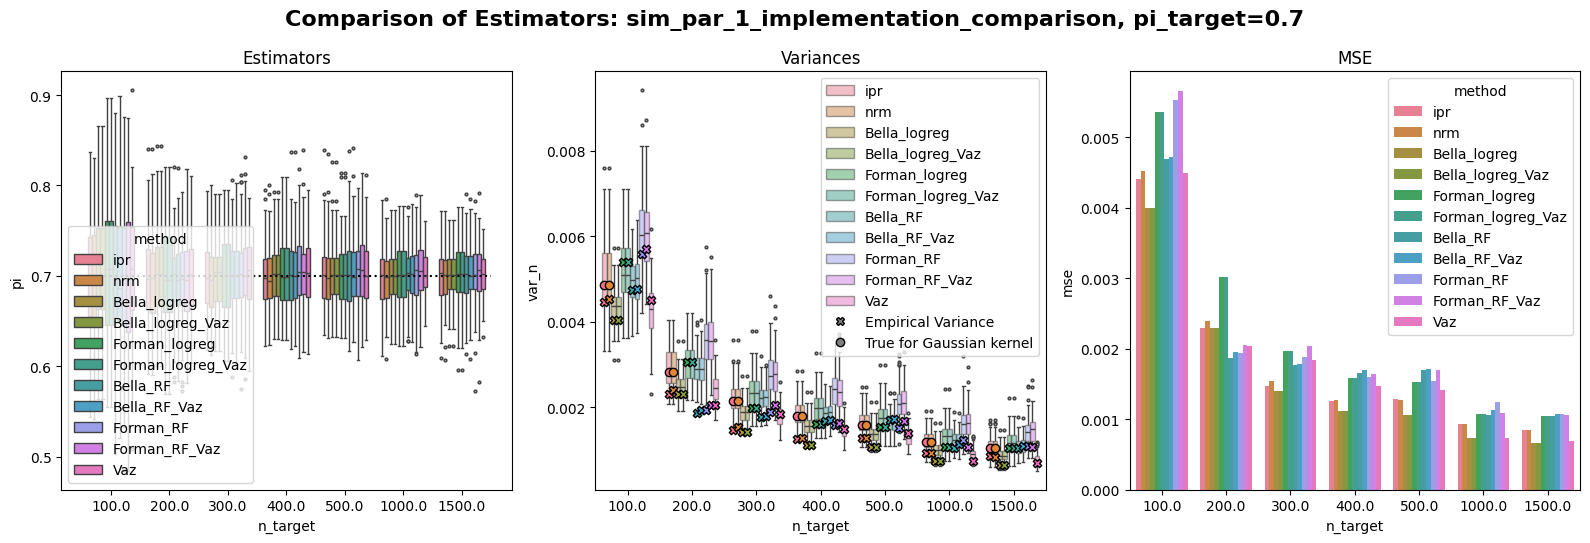

In [59]:
method_names = ['ipr', 'nrm', 
                'Bella_logreg', 'Bella_logreg_Vaz', 'Forman_logreg', 'Forman_logreg_Vaz',
                'Bella_RF', 'Bella_RF_Vaz', 'Forman_RF', 'Forman_RF_Vaz',
                'Vaz'] 
plot_two_plots('sim_par_1_implementation_comparison', 0.7, '07')

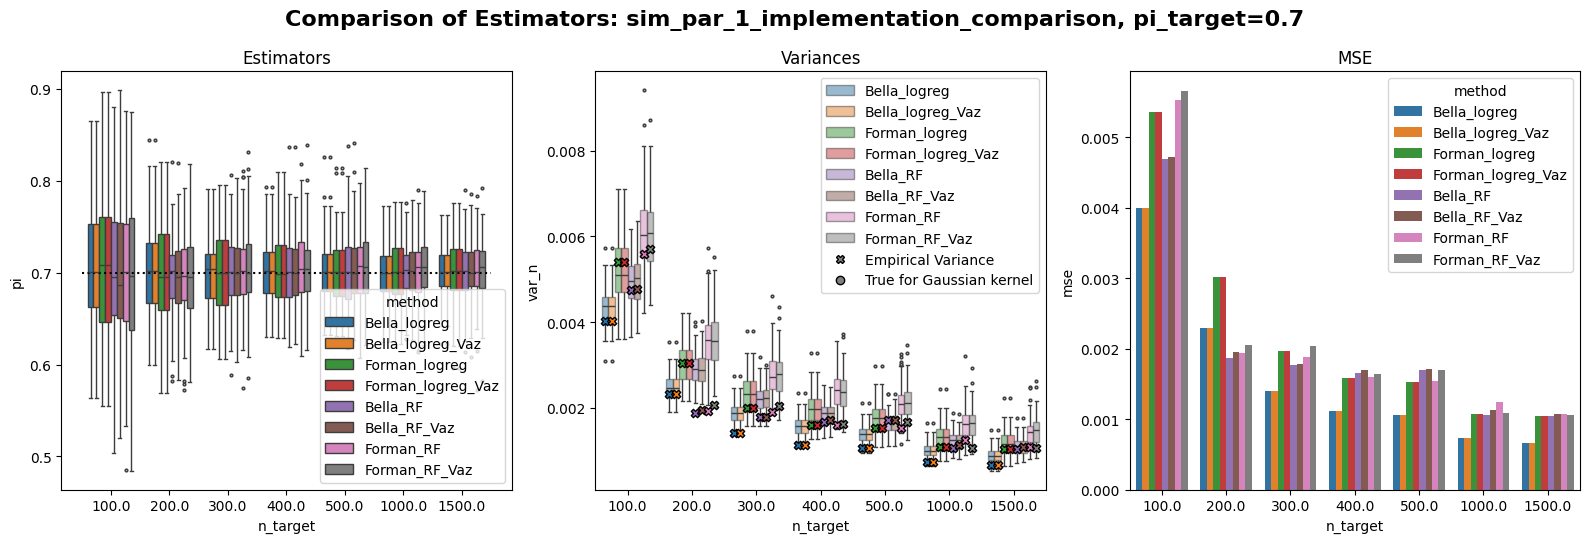

In [58]:
method_names = ['Bella_logreg', 'Bella_logreg_Vaz', 'Forman_logreg', 'Forman_logreg_Vaz',
                'Bella_RF', 'Bella_RF_Vaz', 'Forman_RF', 'Forman_RF_Vaz'] 
plot_two_plots('sim_par_1_implementation_comparison', 0.7, '07')

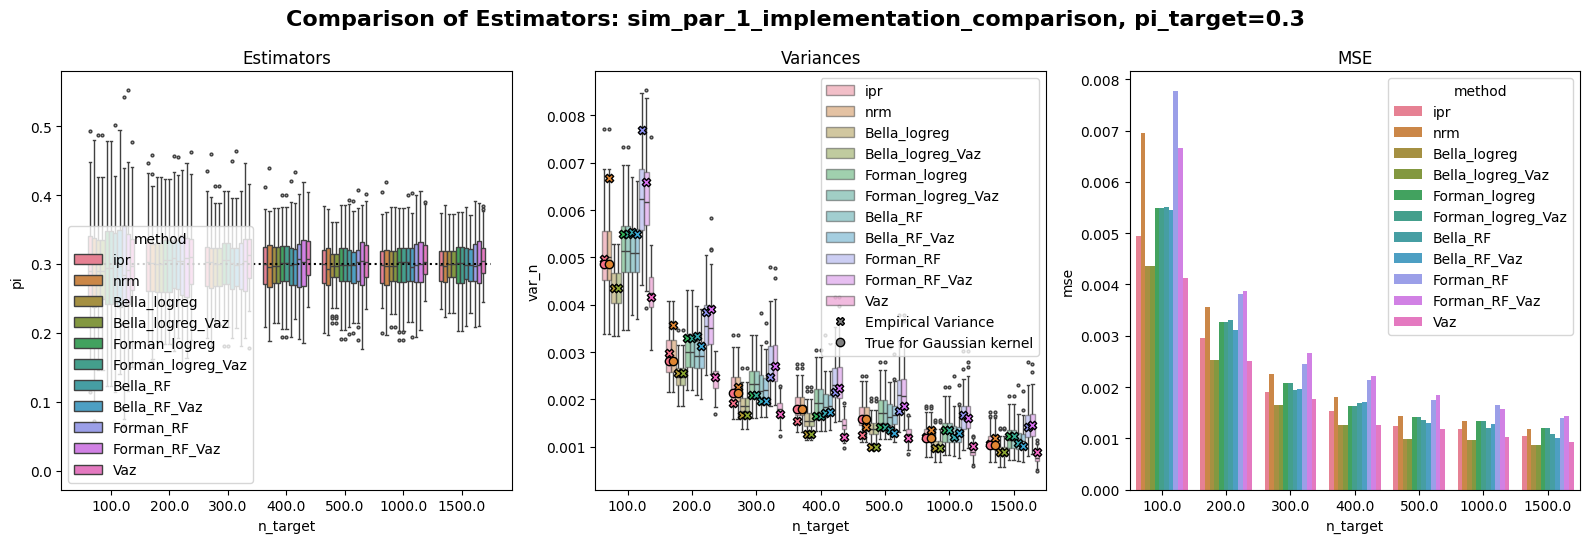

In [54]:
method_names = ['ipr', 'nrm', 
                'Bella_logreg', 'Bella_logreg_Vaz', 'Forman_logreg', 'Forman_logreg_Vaz',
                'Bella_RF', 'Bella_RF_Vaz', 'Forman_RF', 'Forman_RF_Vaz',
                'Vaz'] 
plot_two_plots('sim_par_1_implementation_comparison', 0.3, '03')

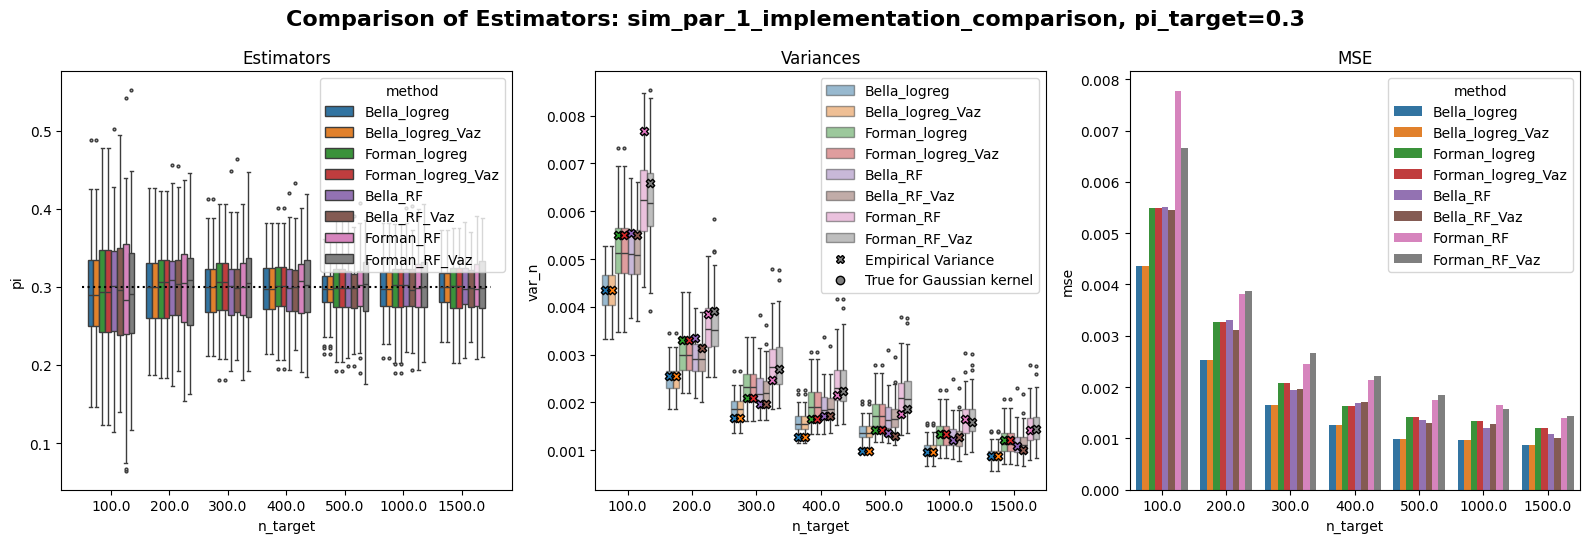

In [55]:
method_names = ['Bella_logreg', 'Bella_logreg_Vaz', 'Forman_logreg', 'Forman_logreg_Vaz',
                'Bella_RF', 'Bella_RF_Vaz', 'Forman_RF', 'Forman_RF_Vaz'] 
plot_two_plots('sim_par_1_implementation_comparison', 0.3, '03')

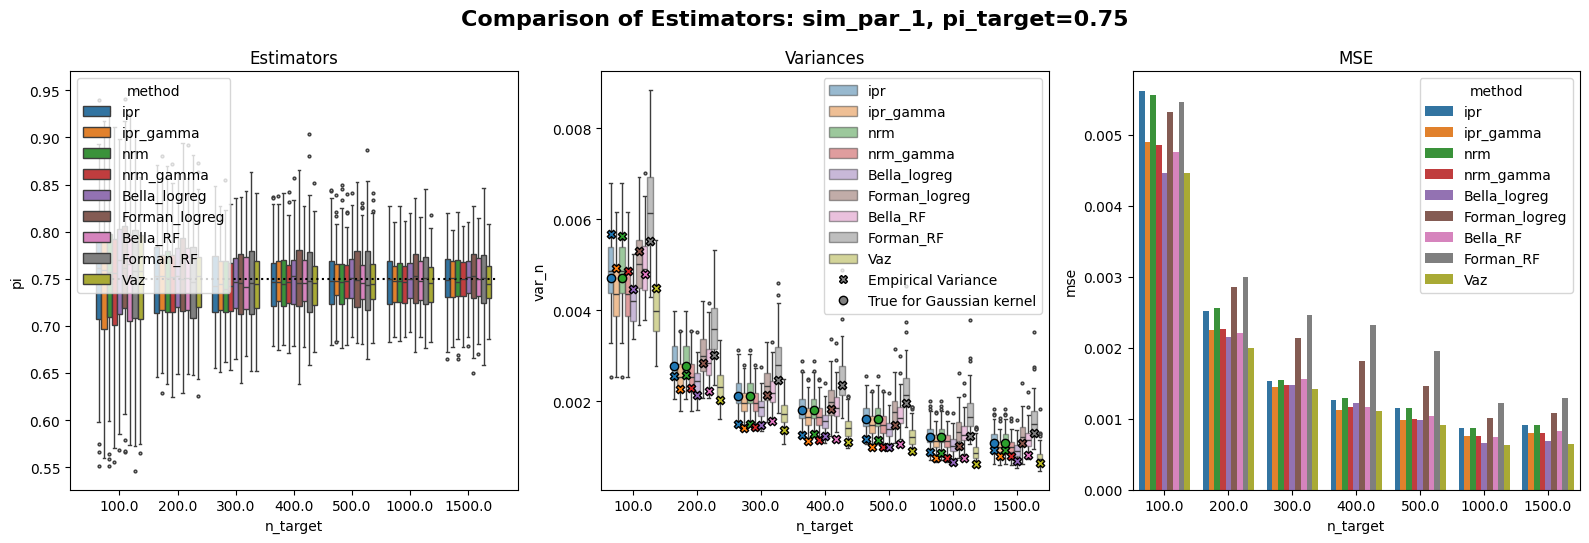

In [10]:
method_names = ['ipr', 'ipr_gamma', 'nrm', 'nrm_gamma', 'Bella_logreg', 'Forman_logreg', 'Bella_RF', 'Forman_RF', 'Vaz'] 

scen = ['sim_par_1']
pi_targets = [0.75]
pi_targets_names = ['075']


for i in range(1):
    plot_two_plots(scen[i], pi_targets[i], pi_targets_names[i])

## Varying n_target

### Our methods: gamma selection

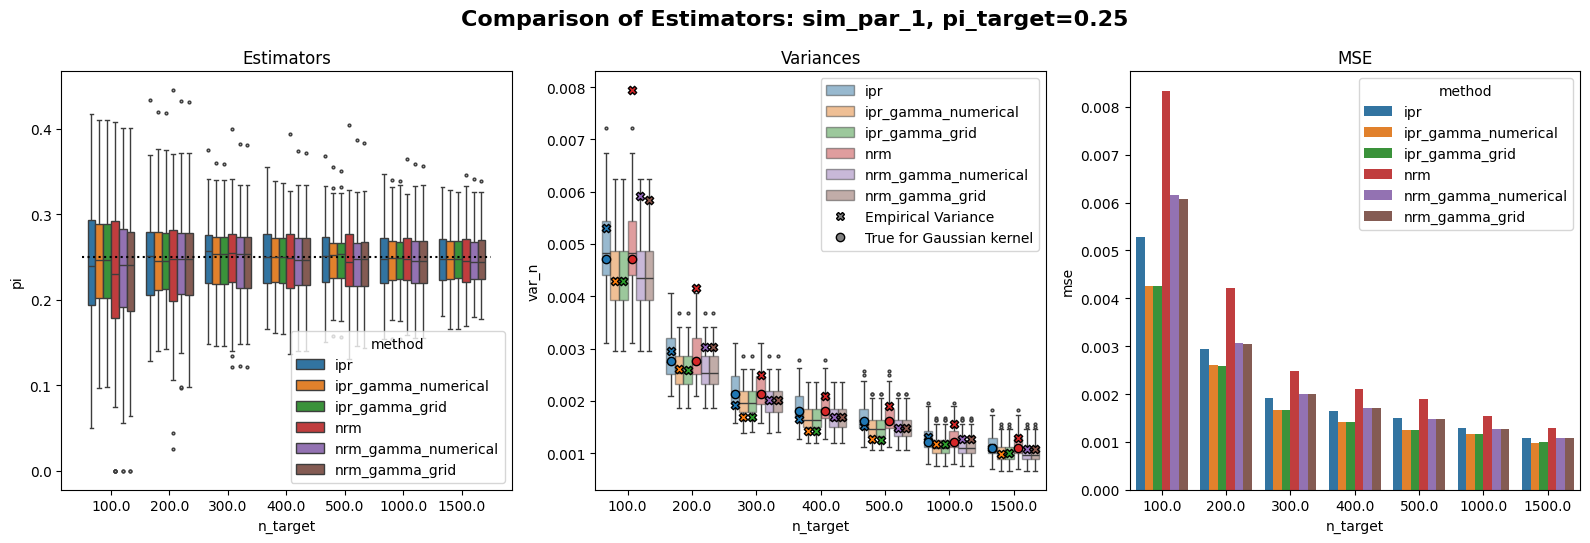

In [60]:
method_names = ['ipr', 'ipr_gamma_numerical', 'ipr_gamma_grid',
                'nrm', 'nrm_gamma_numerical', 'nrm_gamma_grid']

scen = ['sim_par_1']
pi_targets = [0.25]
pi_targets_names = ['025']


for i in range(1):
    plot_two_plots(scen[i], pi_targets[i], pi_targets_names[i])

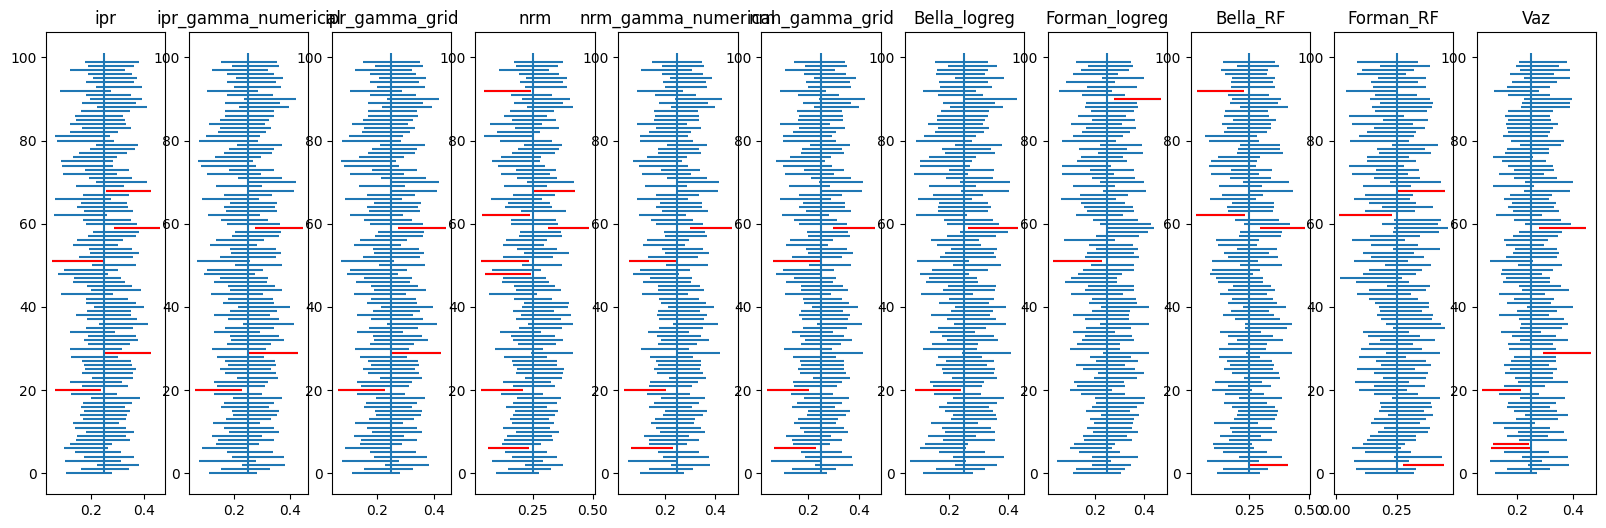

In [20]:
plot_CI('sim_par_1', '025', n_target=300)

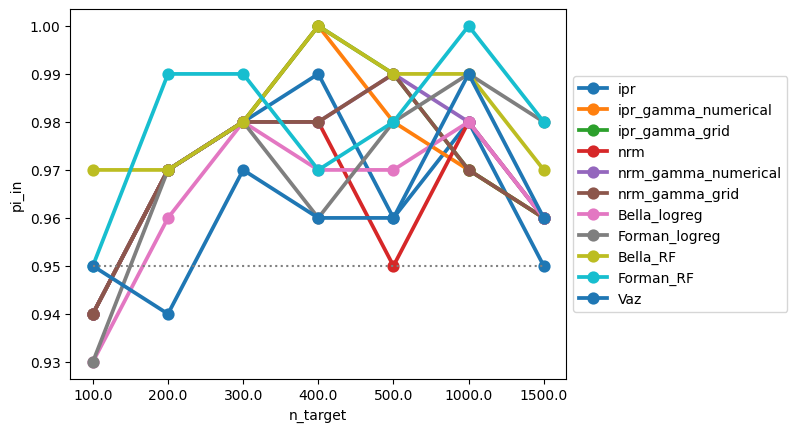

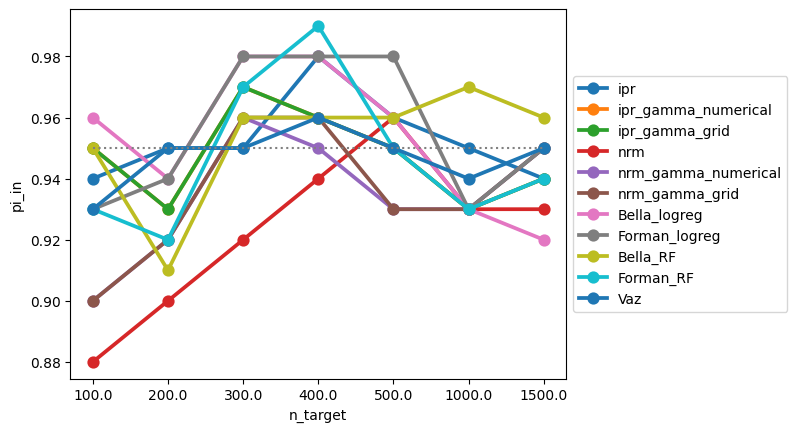

In [70]:
plot_coverage('sim_par_1', 0.75, '075')
plot_coverage('sim_par_1', 0.25, '025')

### All methods

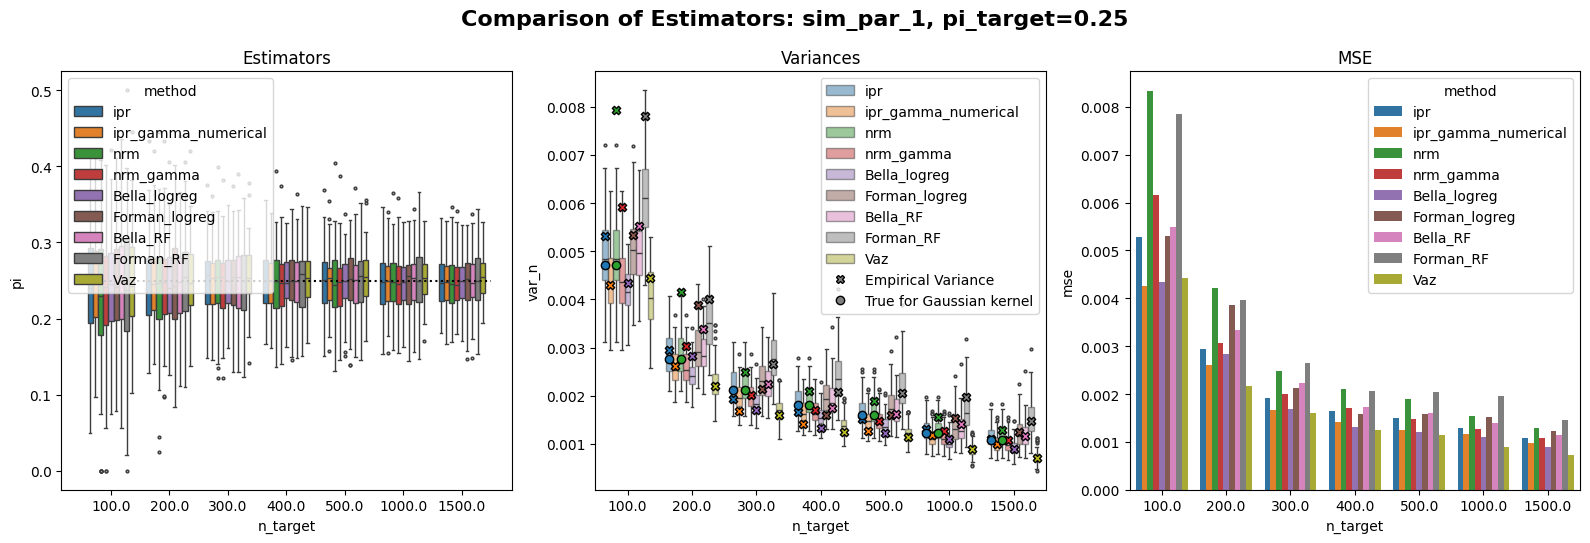

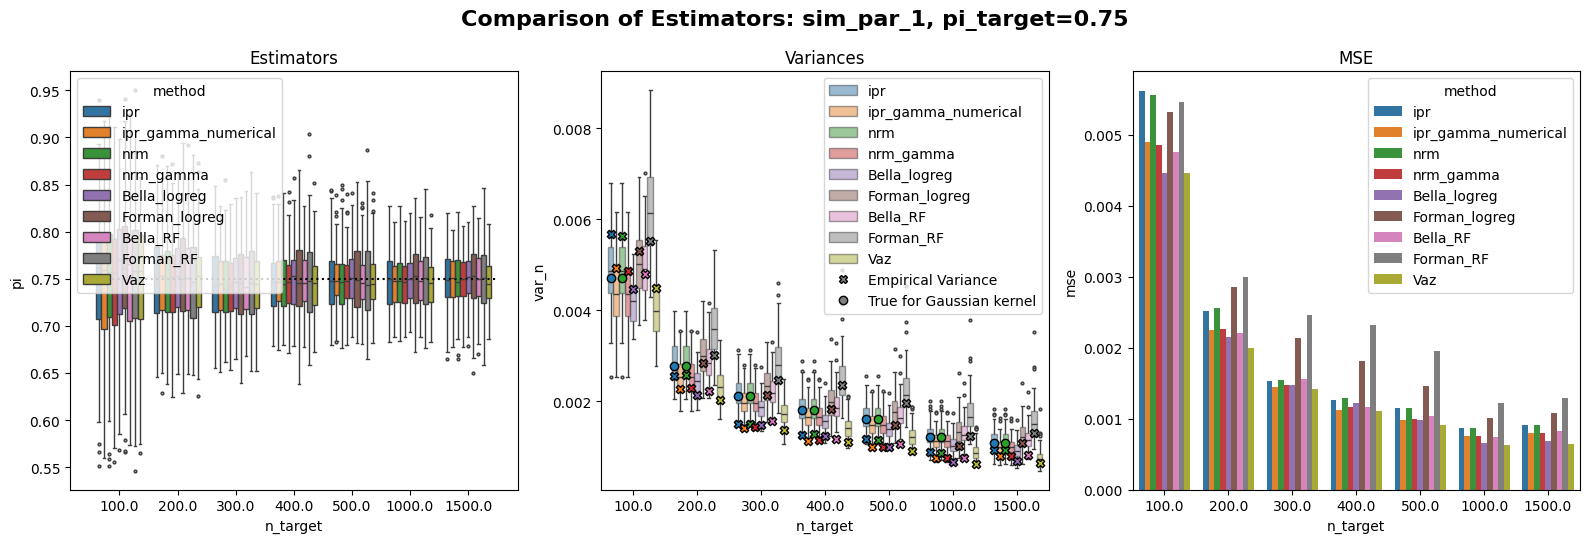

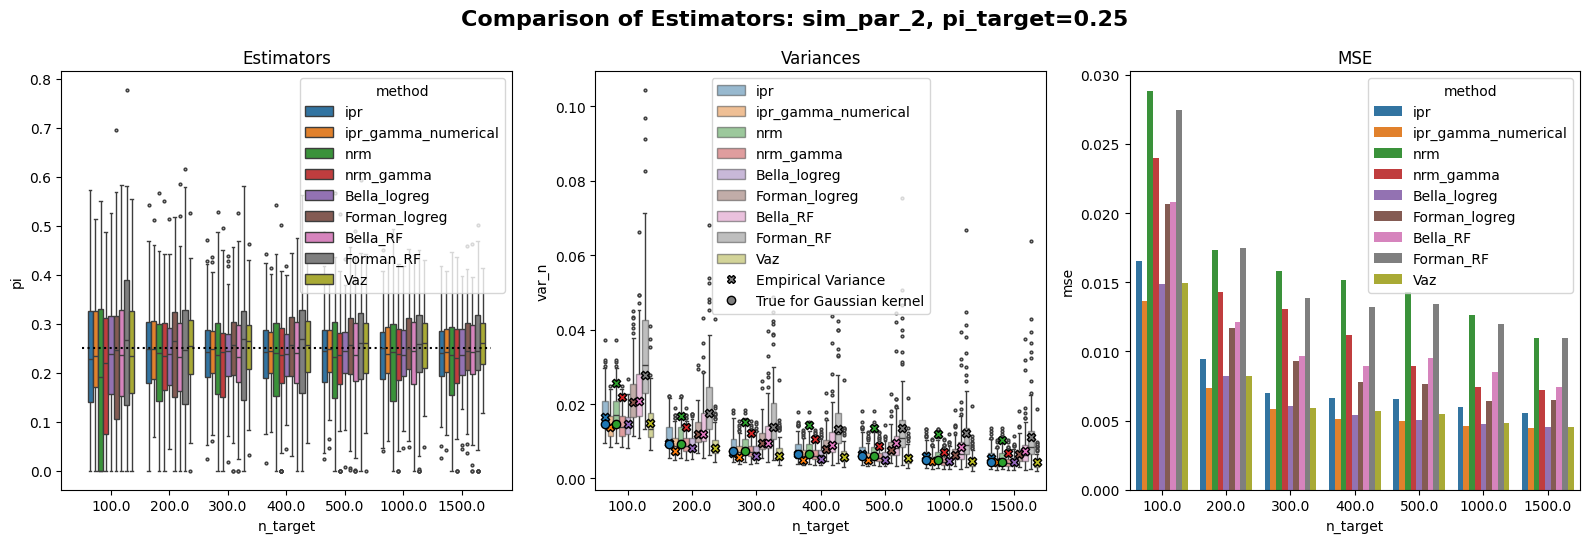

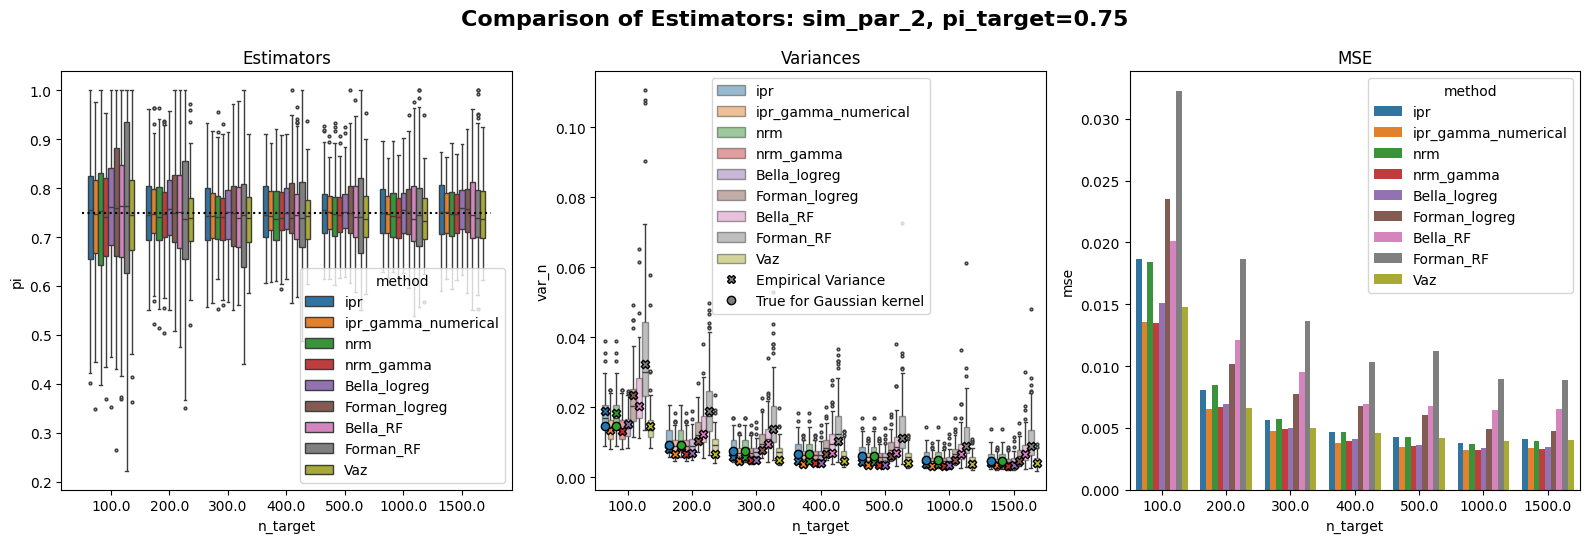

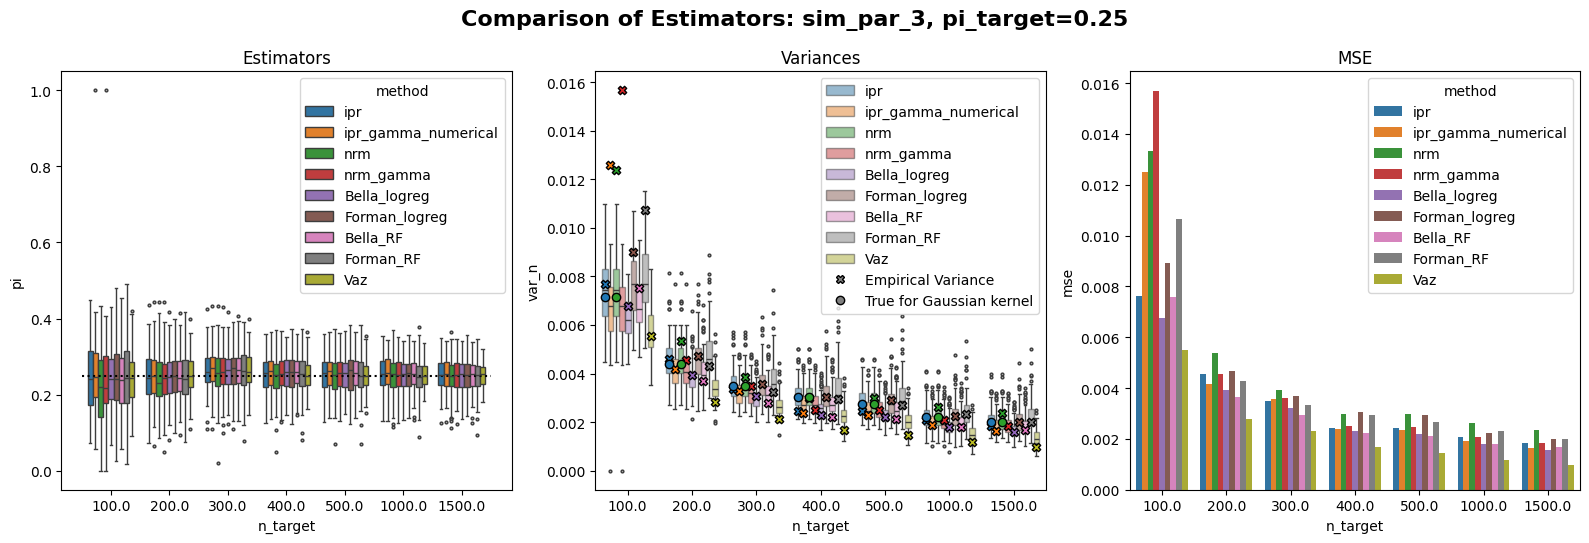

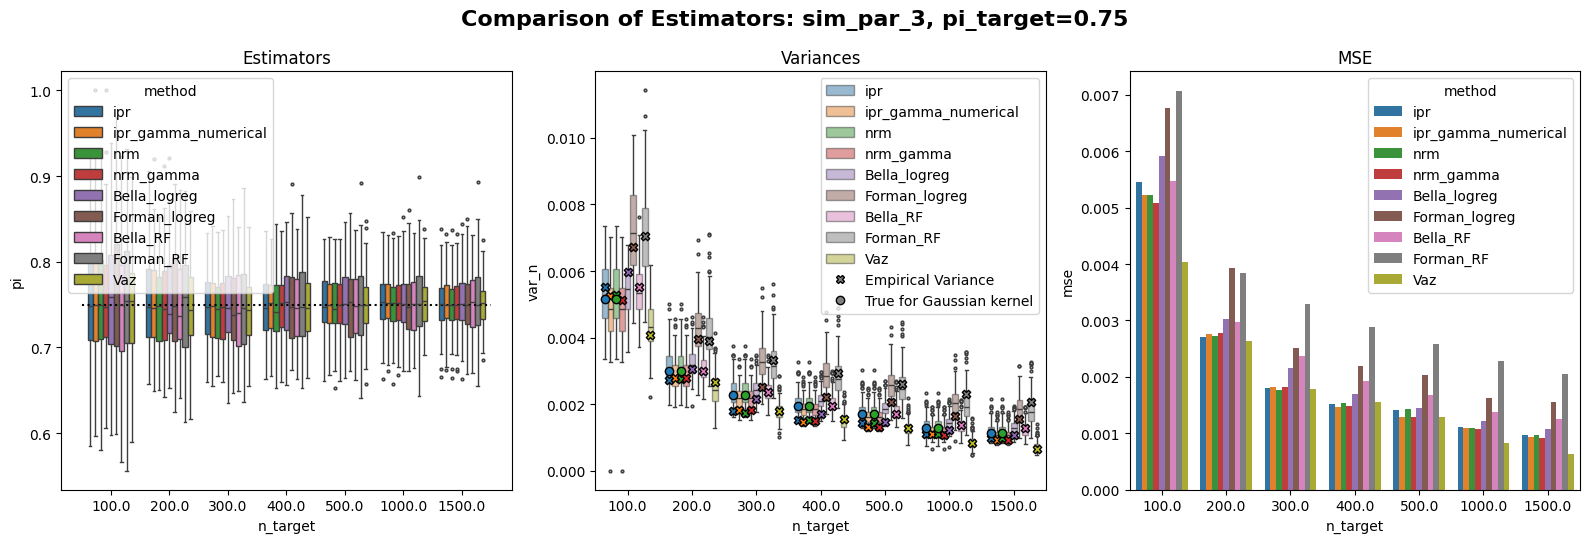

In [64]:
method_names = ['ipr', 'ipr_gamma_numerical', 'nrm', 'nrm_gamma', 'Bella_logreg', 'Forman_logreg', 'Bella_RF', 'Forman_RF', 'Vaz'] 

scen = ['sim_par_1','sim_par_1','sim_par_2','sim_par_2','sim_par_3','sim_par_3']
pi_targets = [0.25, 0.75,0.25, 0.75,0.25, 0.75]
pi_targets_names = ['025', '075','025', '075','025', '075']


for i in range(6):
    plot_two_plots(scen[i], pi_targets[i], pi_targets_names[i])

## Varying n_target=n_source

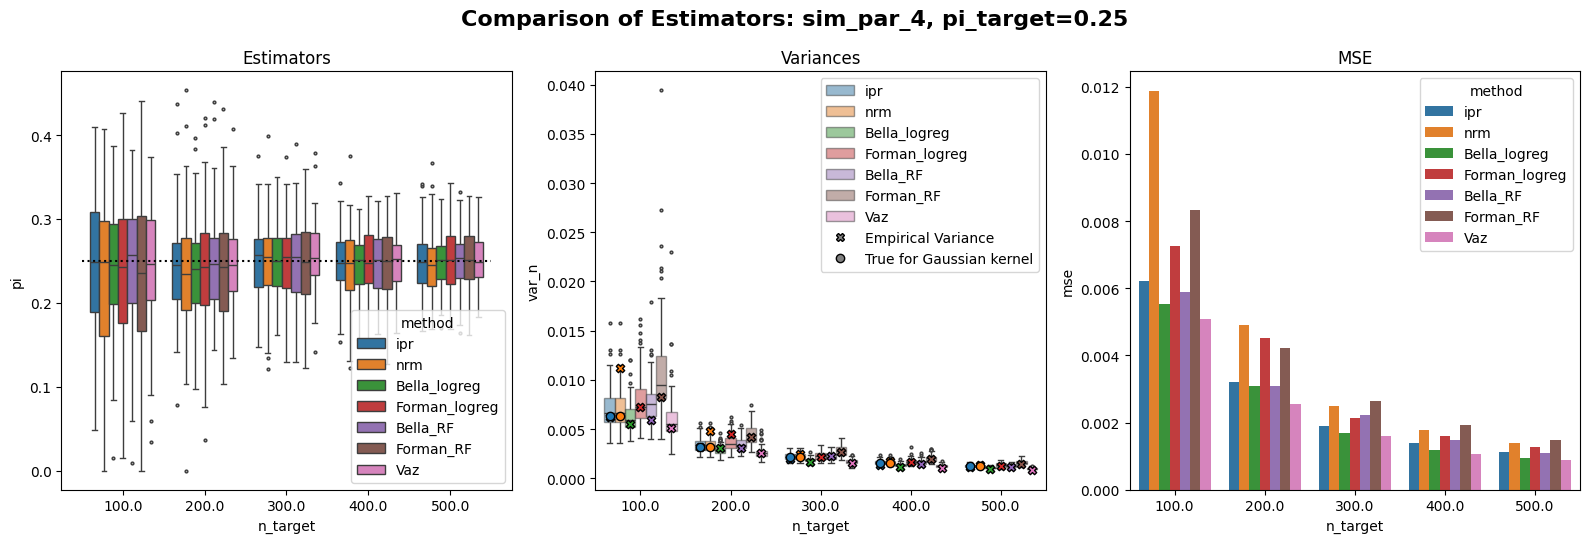

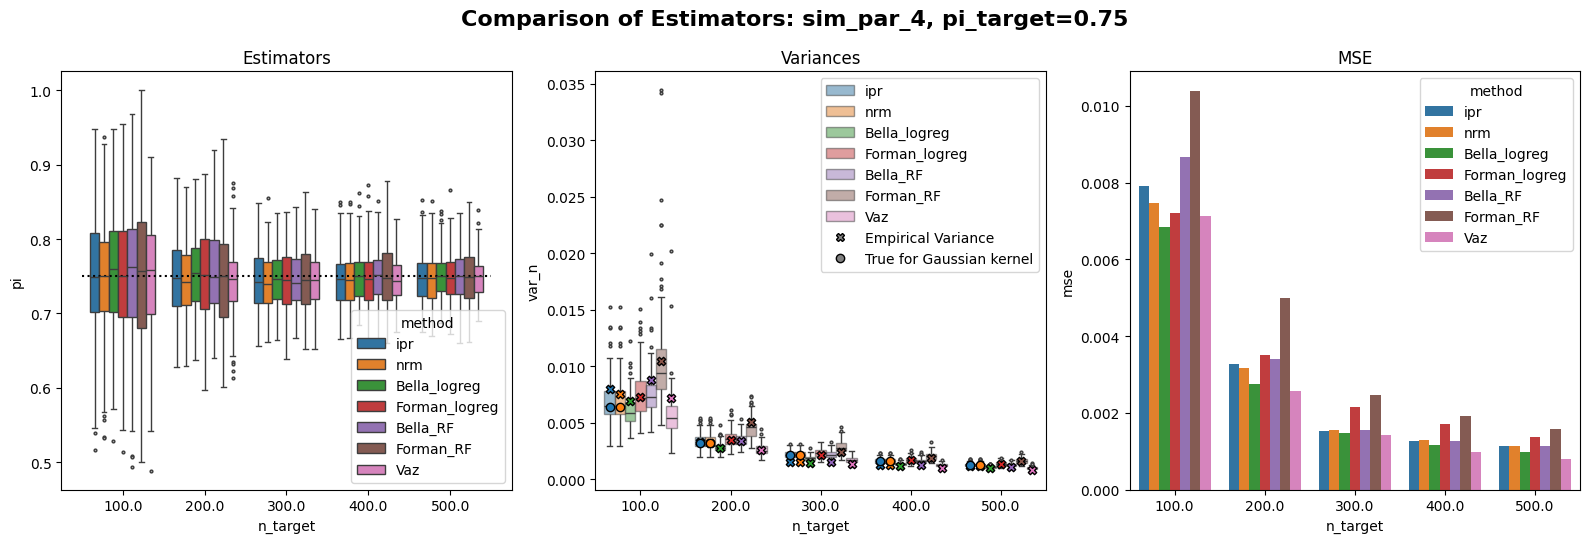

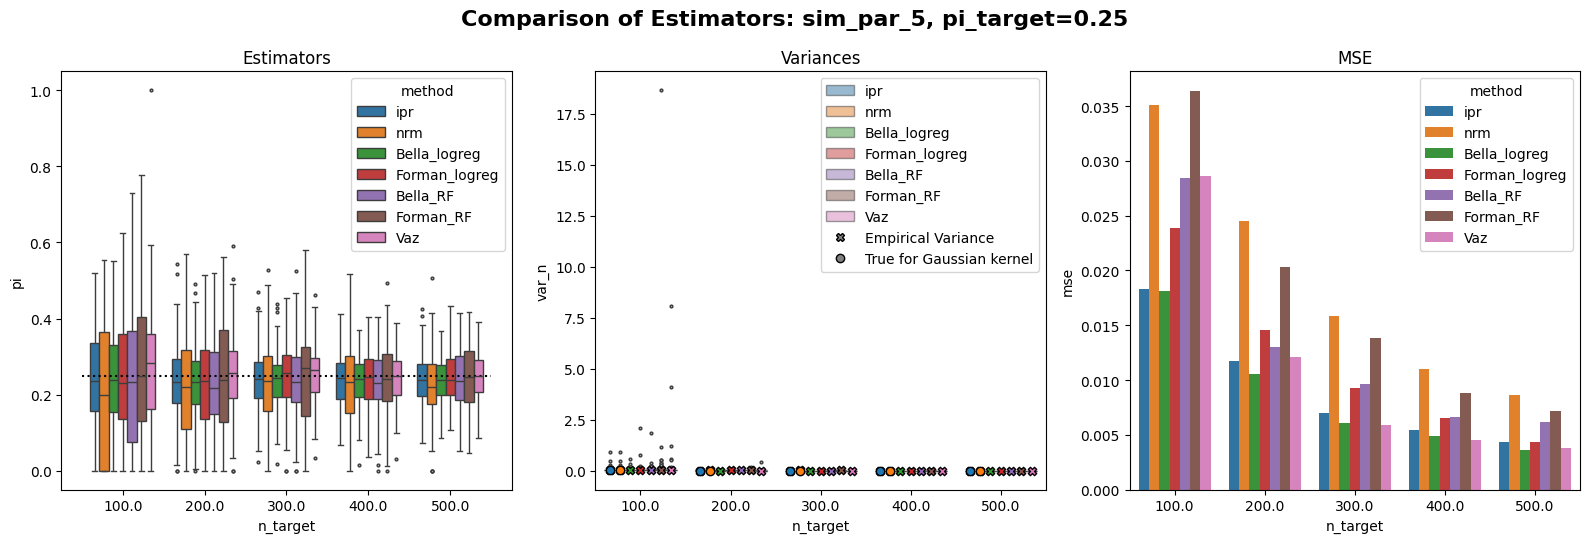

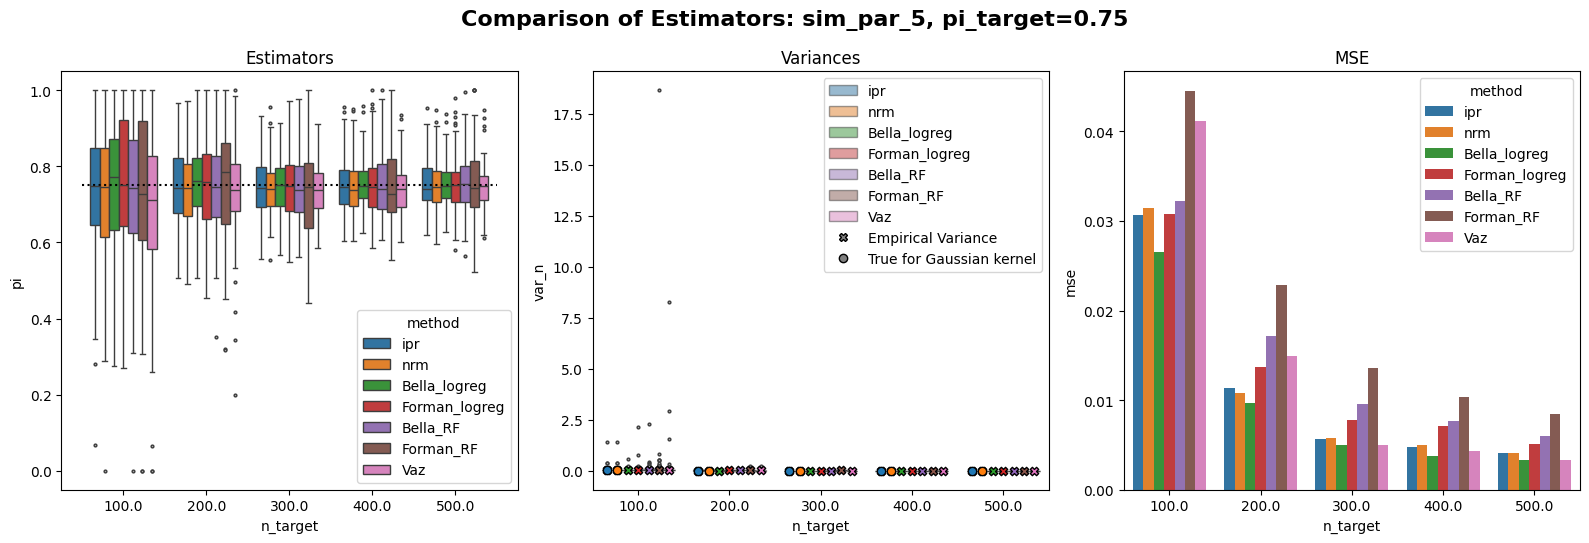

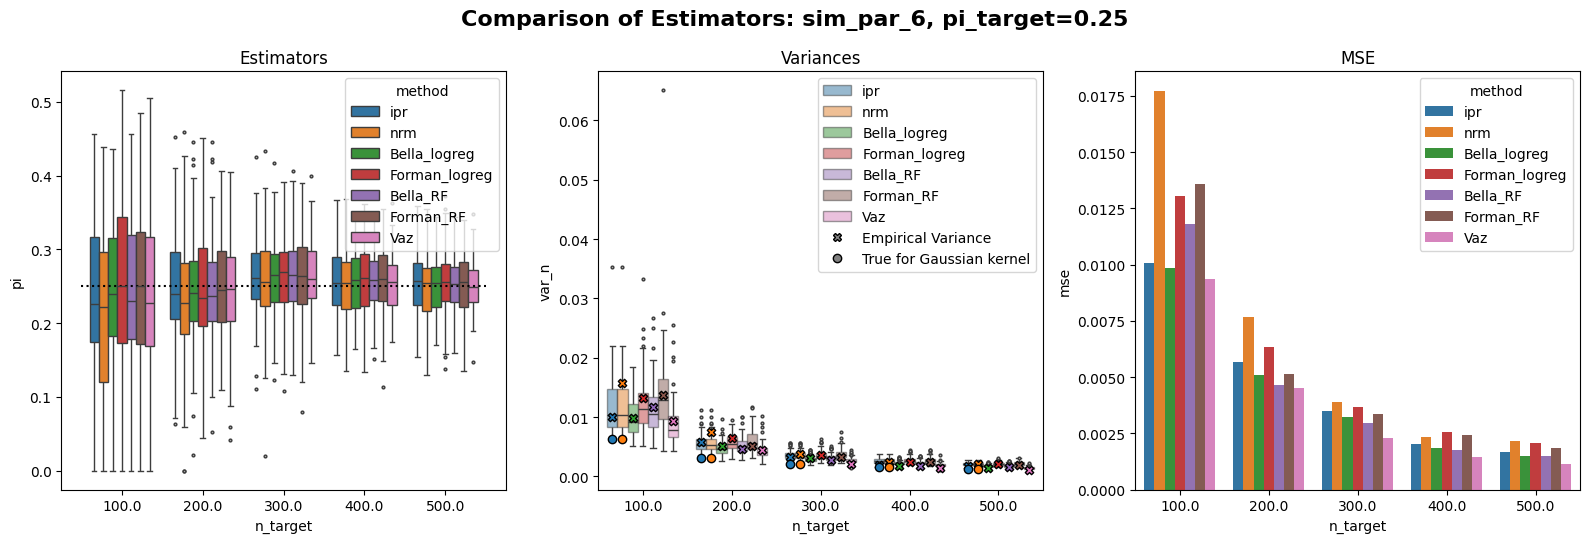

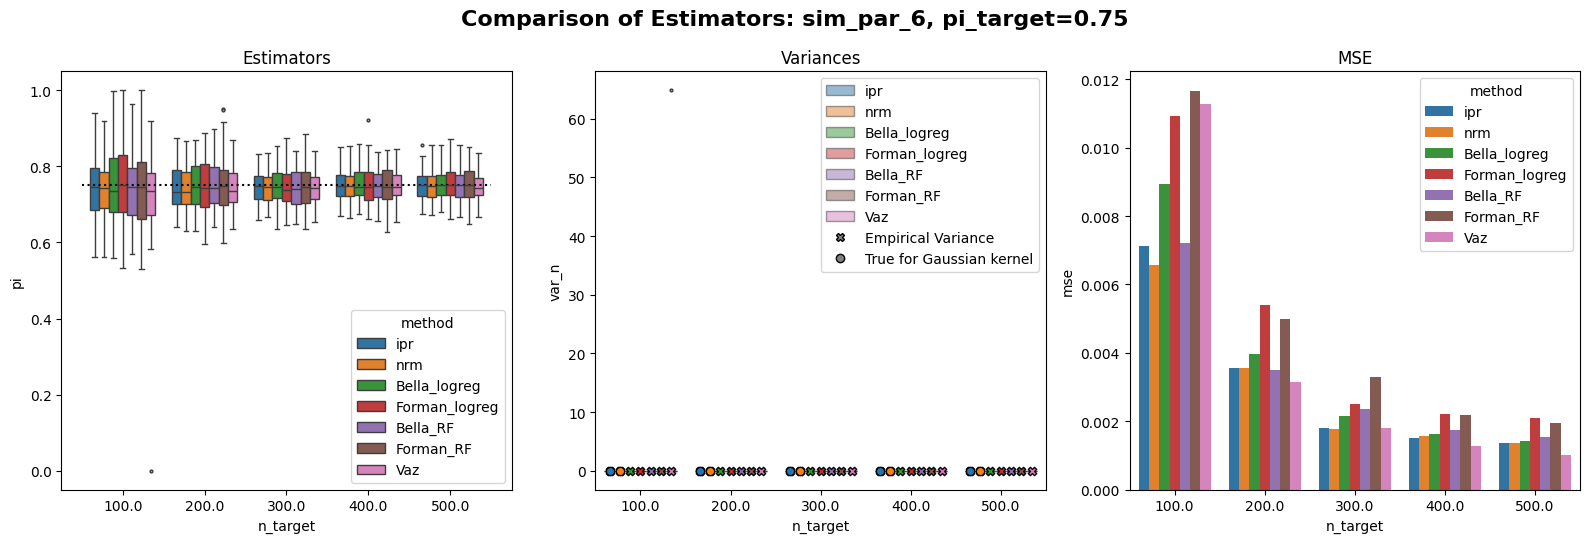

In [30]:
method_names = ['ipr', 'nrm', 'Bella_logreg', 'Forman_logreg', 'Bella_RF', 'Forman_RF', 'Vaz'] 
# method_names = ['ipr', 'nrm', 'Bella_logreg', 'Forman_logreg'] 

scen = ['sim_par_4','sim_par_4','sim_par_5','sim_par_5','sim_par_6','sim_par_6']
pi_targets = [0.25, 0.75,0.25, 0.75,0.25, 0.75]
pi_targets_names = ['025', '075','025', '075','025', '075']


for i in range(6):
    plot_two_plots(scen[i], pi_targets[i], pi_targets_names[i])

In [126]:
sim_scenario = 'sim_par_1'
pi_target_name = '075'
method_names = ['ipr', 'nrm', 'Bella_logreg', 'Forman_logreg', 'Bella_RF', 'Forman_RF', 'Vaz'] 
method_names = ['ipr', 'ipr_gamma', 'nrm', 'nrm_gamma', 'Bella_logreg', 'Forman_logreg', 'Bella_RF', 'Forman_RF', 'Vaz'] 

In [127]:
df_list = []

for m in method_names:
    df_tmp = pd.read_csv('results/'+sim_scenario+'/'+m+'_pi_target'+pi_target_name+'.csv')
    df_tmp['method'] = m
    df_list.append(df_tmp)

df = pd.concat(df_list, ignore_index=True)
df['method'] = pd.Categorical(df['method'], categories=method_names, ordered=True)

df_var = df.groupby(['method', 'n_target'], observed=True).agg(var_emp=('pi', lambda x: np.var(x, ddof=1))).reset_index()
df_merged = pd.merge(df, df_var, on=['n_target', 'method'], how='left')


In [128]:
from scipy.stats import norm

In [129]:


df_tmp1 = pd.read_csv('results/'+sim_scenario+'/'+'rbf'+'_pi_target'+pi_target_name+'.csv')
df_tmp1['method'] = 'ipr'
df_tmp2 = pd.read_csv('results/'+sim_scenario+'/'+'rbf'+'_pi_target'+pi_target_name+'.csv')
df_tmp2['method'] = 'nrm'
df_tmp1 = pd.concat([df_tmp1, df_tmp2], ignore_index=True)
df_tmp1['method'] = pd.Categorical(df_tmp1['method'], categories=method_names, ordered=True)
df_tmp1['var_gauss_n'] = df_tmp['var_n']
df_tmp1 = df_tmp1[['n_target', 'var_gauss_n', 'method']]

df = pd.merge(df, df_tmp1, on=['n_target', 'method'], how='left')

In [130]:
df

,n_plus,n_minus,n_target,pi_target,pi,var_n,var,seed,method,var_gauss_n
0,150,150,100.0,0.75,0.647763,0.003273,0.140261,0.0,ipr,0.003880
1,150,150,200.0,0.75,0.706622,0.002698,0.147184,0.0,ipr,0.002359
2,150,150,300.0,0.75,0.697851,0.002053,0.123184,0.0,ipr,0.001763
3,150,150,400.0,0.75,0.697968,0.001642,0.103699,0.0,ipr,0.001384
4,150,150,500.0,0.75,0.701213,0.001466,0.095579,0.0,ipr,0.001189
...,...,...,...,...,...,...,...,...,...,...
6295,150,150,300.0,0.75,0.743714,0.002175,1.305075,99.0,Vaz,NaN
6296,150,150,400.0,0.75,0.780462,0.001740,1.218069,99.0,Vaz,NaN
6297,150,150,500.0,0.75,0.772379,0.001556,1.244745,99.0,Vaz,NaN
6298,150,150,1000.0,0.75,0.779399,0.001141,1.483467,99.0,Vaz,NaN


In [131]:
alpha = 0.05
q = norm.ppf(1-alpha/2)

In [132]:
df['CI_L_asymp'] = df['pi'] - q*np.sqrt(df['var_n'])
df['CI_U_asymp'] = df['pi'] + q*np.sqrt(df['var_n'])

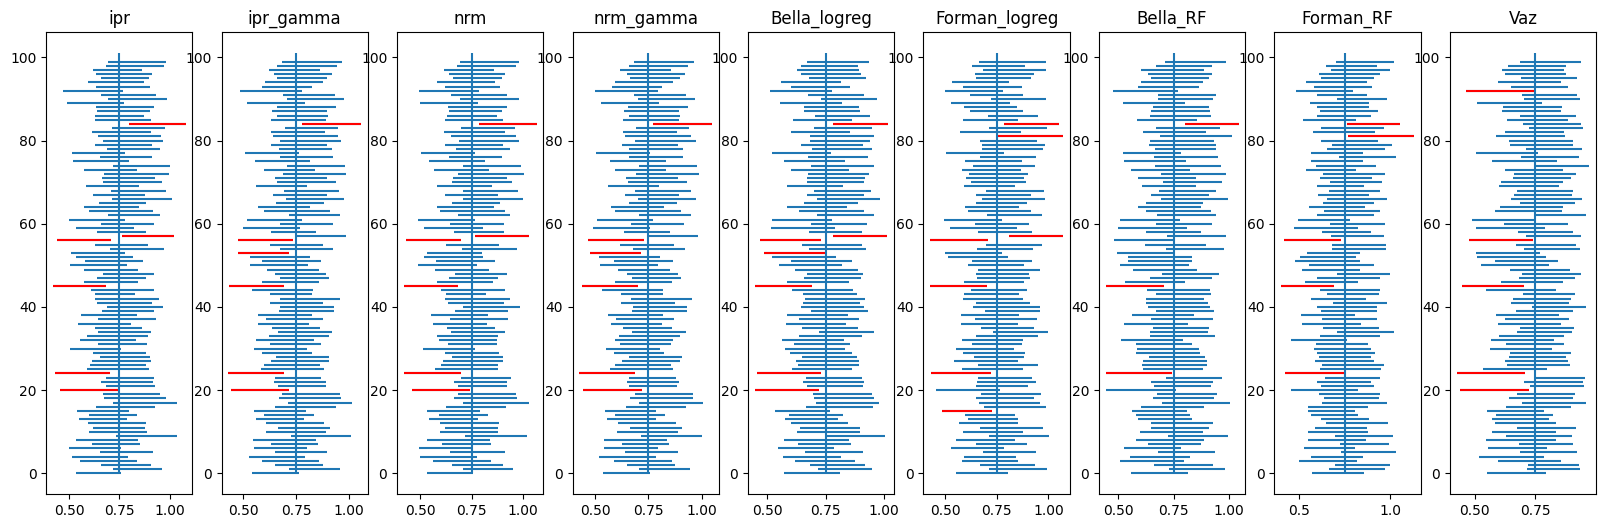

In [134]:
fig, axes = plt.subplots(1,len(method_names), figsize=(20,6))
for method_ind, method in zip(range(len(method_names)), method_names):
    df_tmp = df[(df['method'] == method) & (df['n_target'] == 100)] 
    df_tmp = df_tmp.reset_index()  
    
    for i in range(df_tmp.shape[0]):
        axes[method_ind].hlines(df_tmp.loc[i, 'seed'], df_tmp.loc[i, 'CI_L_asymp'], df_tmp.loc[i, 'CI_U_asymp'])
        if df_tmp.loc[i, 'pi_target'] < df_tmp.loc[i, 'CI_L_asymp'] or df_tmp.loc[i, 'pi_target'] > df_tmp.loc[i, 'CI_U_asymp']:
            axes[method_ind].hlines(df_tmp.loc[i, 'seed'], df_tmp.loc[i, 'CI_L_asymp'], df_tmp.loc[i, 'CI_U_asymp'], color='red')
    axes[method_ind].vlines(df_tmp.loc[i, 'pi_target'], 0, 101)
    axes[method_ind].set_title(method)
plt.show()

In [114]:
df['CI_L_gauss'] = df['pi'] - q*np.sqrt(df['var_gauss_n'])
df['CI_U_gauss'] = df['pi'] + q*np.sqrt(df['var_gauss_n'])

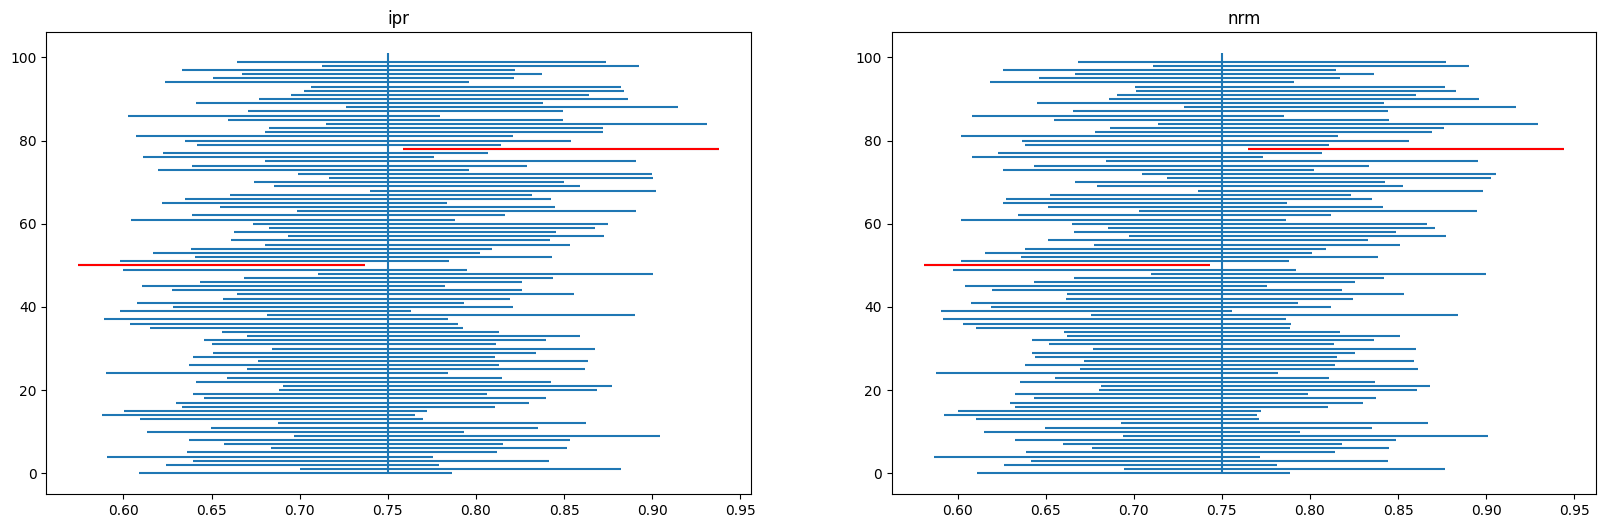

In [115]:
fig, axes = plt.subplots(1,len(method_names[:2]), figsize=(20,6))
for method_ind, method in zip(range(len(method_names[:2])), method_names[:2]):
    df_tmp = df[(df['method'] == method) & (df['n_target'] == 300)] 
    df_tmp = df_tmp.reset_index()  
    
    for i in range(df_tmp.shape[0]):
        axes[method_ind].hlines(df_tmp.loc[i, 'seed'], df_tmp.loc[i, 'CI_L_asymp'], df_tmp.loc[i, 'CI_U_asymp'])
        if df_tmp.loc[i, 'pi_target'] < df_tmp.loc[i, 'CI_L_asymp'] or df_tmp.loc[i, 'pi_target'] > df_tmp.loc[i, 'CI_U_asymp']:
            axes[method_ind].hlines(df_tmp.loc[i, 'seed'], df_tmp.loc[i, 'CI_L_asymp'], df_tmp.loc[i, 'CI_U_asymp'], color='red')
    axes[method_ind].vlines(df_tmp.loc[i, 'pi_target'], 0, 101)
    axes[method_ind].set_title(method)
plt.show()

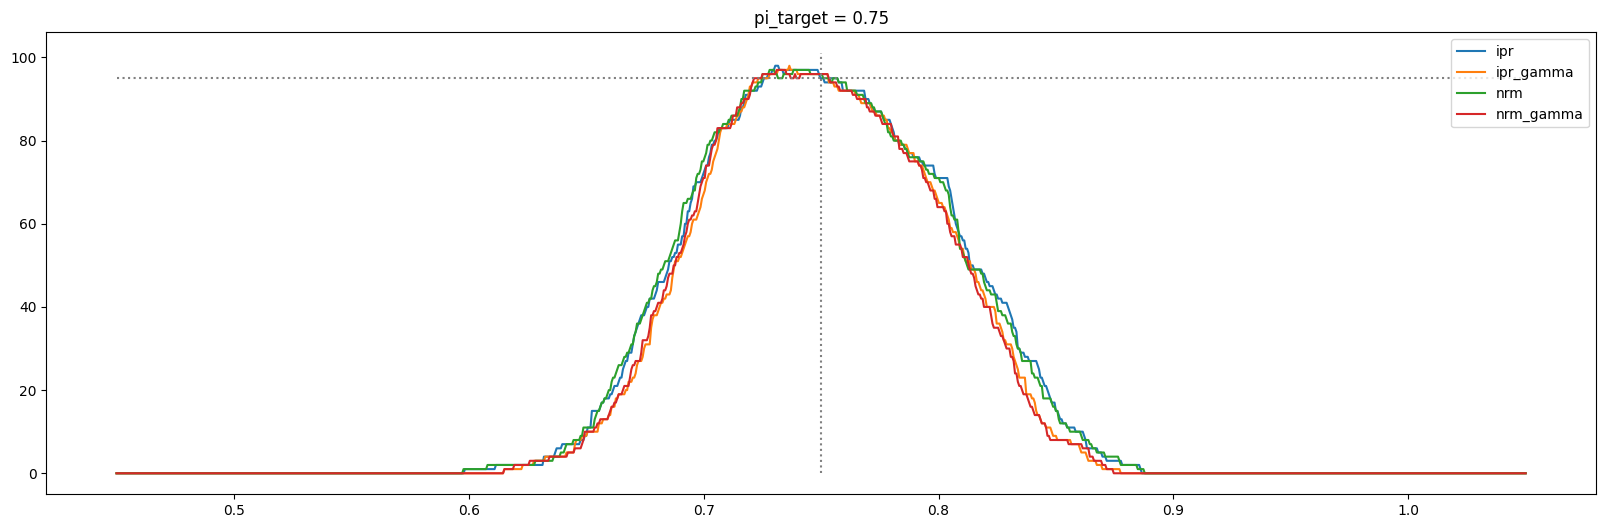

In [136]:
fig, axes = plt.subplots(1,1, figsize=(20,6))
for method_ind, method in zip(range(len(method_names[:4])), method_names[:4]):
    df_tmp = df[(df['method'] == method) & (df['n_target'] == 1500)] 
    df_tmp = df_tmp.reset_index()

    p=df_tmp.loc[0, 'pi_target']
   
    x_seq = np.linspace(p-0.3,p+0.3, 1000)
    y_seq = np.zeros(1000)
    for j in range(100):
        for i in range(1000):
            if x_seq[i] > df_tmp.loc[j, 'CI_L_asymp'] and x_seq[i] < df_tmp.loc[j, 'CI_U_asymp']:
                y_seq[i] += 1
    axes.plot(x_seq, y_seq, label=method)
axes.vlines(p, 0, 101, linestyle='dotted', color='gray')
axes.legend()
axes.hlines(95, p-0.3,p+0.3, linestyle='dotted', color='gray')
axes.set_title('pi_target = '+str(p))
plt.show()

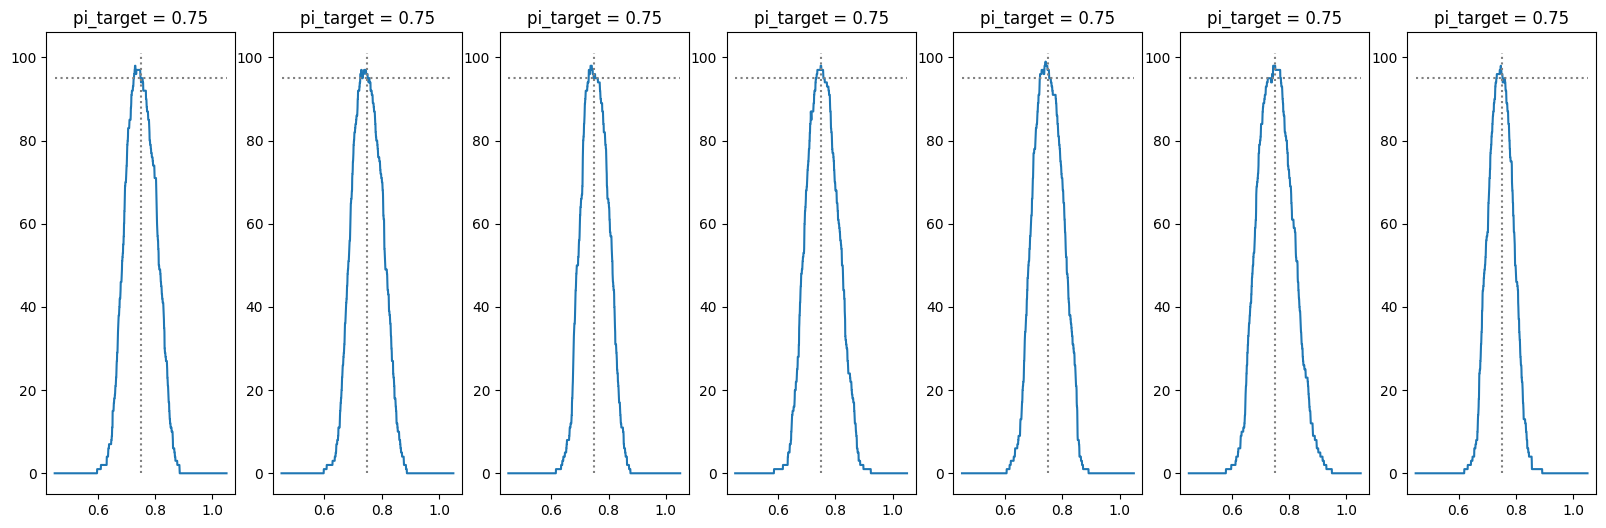

In [74]:
fig, axes = plt.subplots(1,len(method_names), figsize=(20,6))
for method_ind, method in zip(range(len(method_names)), method_names):
    df_tmp = df[(df['method'] == method) & (df['n_target'] == 1500)] 
    df_tmp = df_tmp.reset_index()

    p=df_tmp.loc[0, 'pi_target']
   
    x_seq = np.linspace(p-0.3,p+0.3, 1000)
    y_seq = np.zeros(1000)
    for j in range(100):
        for i in range(1000):
            if x_seq[i] > df_tmp.loc[j, 'CI_L_asymp'] and x_seq[i] < df_tmp.loc[j, 'CI_U_asymp']:
                y_seq[i] += 1
    axes[method_ind].plot(x_seq, y_seq)
    axes[method_ind].vlines(p, 0, 101, linestyle='dotted', color='gray')
    axes[method_ind].hlines(95, p-0.3,p+0.3, linestyle='dotted', color='gray')
    axes[method_ind].set_title('pi_target = '+str(p))
plt.show()

In [14]:
method_names = ['ipr_gamma_numerical', 'ipr_gamma_grid',
                'nrm_gamma_numerical', 'nrm_gamma_grid']
sim_scenario = 'sim_par_1'
pi_targets = 0.25
pi_target_name = '025'

df_list = []
for m in method_names:
    df_tmp = pd.read_csv('results/'+sim_scenario+'/'+m+'_pi_target'+pi_target_name+'.csv')
    df_tmp['method'] = m
    df_list.append(df_tmp)

df = pd.concat(df_list, ignore_index=True)
df['method'] = pd.Categorical(df['method'], categories=method_names, ordered=True)


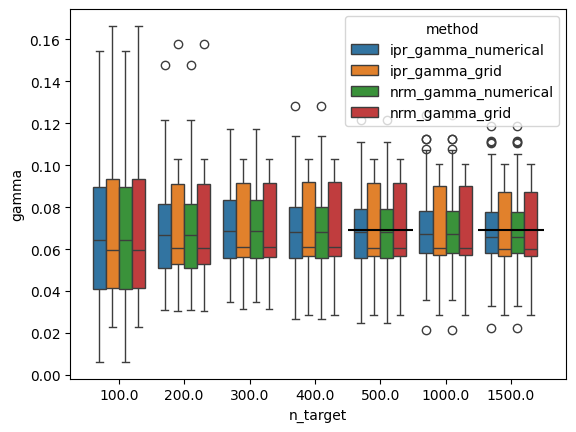

In [23]:
sns.boxplot(df, x='n_target', y='gamma', hue='method')
plt.hlines(0.06911013, 5.5,6.5, color='black')
plt.hlines(0.06910939, 3.5,4.5, color='black')